<a href="https://colab.research.google.com/github/HHansi/Applied-AI-Course/blob/main/Image%20Processing/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bumble Bee or Honey Bee?

![](https://github.com/HHansi/Applied-AI-Course/blob/main/Images/Honey-Bee-V.-Bumble-Bee.png?raw=true) <br>
[image source](https://www.modernpest.com/blog/bumble-bees-vs-honeybees/)

Gaining insight into changing bee populations is critical to understand the effects of colony collapses. Bee images were used as an easy way to gather the details. However, experts need to manually analyse the images to identify each bee type. Let's look for a machine learning-based solution, to make this identification more simple and efficient.

More details about this challenge are available [here](https://www.drivendata.org/competitions/8/). 


In [26]:
import os
import pandas as pd

import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# library for evaluation
from sklearn import metrics

# libraries for ML algorithms
from sklearn import svm

In [ ]:
# unzip data
with zipfile.ZipFile("/content/bee_dataset.zip", 'r') as zip_ref: 
    zip_ref.extractall("/content/")

##Load image data sets

In [30]:
# load training data
df_train = pd.read_csv("/content/bee_dataset/train.csv")

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 3969


,id,genus
0,520,1.0
1,3800,1.0
2,3289,1.0
3,2695,1.0
4,4922,1.0


In [31]:
# load testing data
df_test = pd.read_csv("/content/bee_dataset/test.csv")

# summarise the details
print(f'Number of entries: {len(df_test)}')
df_test.head()

Number of entries: 6


,id
0,1
1,2
2,3
3,4
4,5


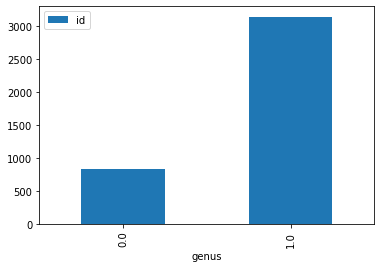

In [32]:
# Summarise label details in training data
temp_df = df_train.groupby('genus').count()
temp_df.plot.bar()

In [47]:
# method to load images
# parameters
# ids - list of image ids
# folder_path - path to image folder
# dim - dimensions to resize images
def load_images(ids, folder_path, dim):
  images = []
  for id in ids:
    image_path = os.path.join(folder_path, "{}.jpg".format(id))
    img = cv2.imread(image_path)

    # Resize if necessary
    if img.shape[0] != dim[1] or img.shape[1] != dim[0]:
      img = cv2.resize(img, dim)
    images.append(img)
  return images

In [48]:
base_dim = (200, 200)

# load train images
train_image_folder = "/content/bee_dataset/train_images"
train_images = load_images(df_train['id'], train_image_folder, base_dim)
print(f'Number of training images loaded: {len(train_images)}')

# load test images
test_image_folder = "/content/bee_dataset/test_images"
test_images = load_images(df_test['id'], test_image_folder, base_dim)
print(f'Number of training images loaded: {len(test_images)}')

Number of training images loaded: 3969
Number of training images loaded: 6


## Feature extraction and model generation

In [49]:
# method to plot confusion matrix
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['0', '1']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

# method to calculate evaluation results
def evaluate(actuals, predictions):
  accuracy = metrics.accuracy_score(actuals, predictions)
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=[0, 1])
  return accuracy, confusion_matrix

### SVM

In [50]:
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=100) 
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evaluation
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return clf

#### M1

- Preprocessing - gray scaling<br>
- Features - image vector<br>
- Algorithm - SVM <br>

In [53]:
# method to get image features
def get_features_m1(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # vectorise/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

(3969, 40000)
Accuracy: 0.7027707808564232


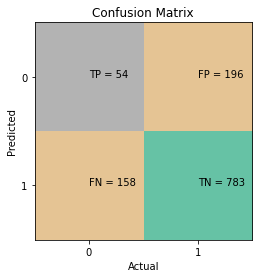

In [54]:
# feature extraction
features_train = get_features_m1(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df['genus'], test_size=0.3, random_state=100)

# train and validation
model = get_svm_predictions(X_train, X_val, y_train, y_val)

Make predictions on test images

In [55]:
# feature extraction - test data
features_test = get_features_m1(test_images)
print(features_test.shape)

# get model predictions
predictions = model.predict(features_test)
print(predictions)

(6, 40000)
[1. 1. 0. 0. 1. 0.]


#### M2

- Preprocessing - gray scaling, smoothing <br>
- Features - image vector<br>
- Algorithm - SVM <br>

To smooth images, we learned 2 commonly used techniques: box filtering and Gaussian filtering. Among them Gaussian filtering is used with this example.

Let's pick a random sample from images to see how smoothing affects them and to get an idea on suitable parameter settings. 

Note - This part is optional for the main flow. 

Image Id: 596
Image Id: 1882
Image Id: 1863
Image Id: 3898
Image Id: 3157


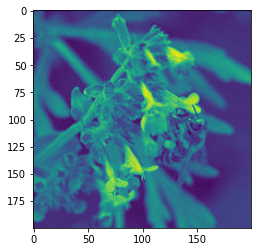

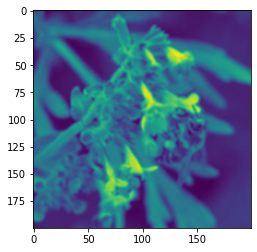

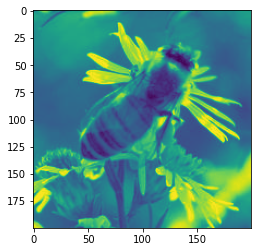

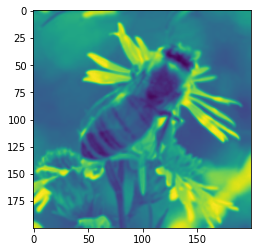

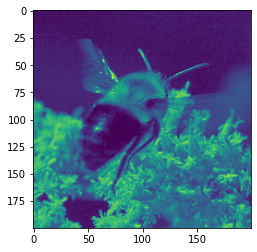

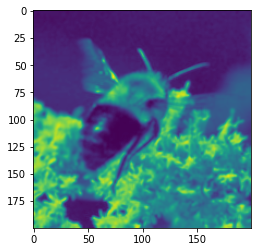

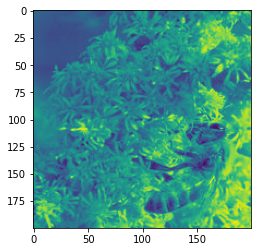

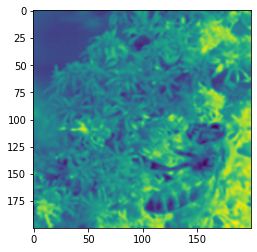

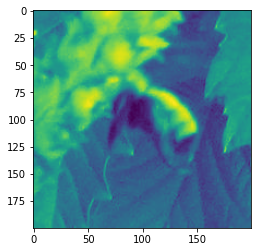

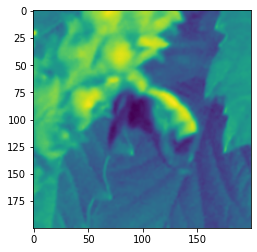

In [ ]:
from random import randint
from random import seed

seed(100)
sample_images = []

# pick random sample of images
for i in range(5):
  value = randint(0, len(images)-1)
  print(f'Image Id: {value}')
  sample_images.append(images[value])

# apply preprocessing and show output images
for img in sample_images:
  img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  plt.imshow(img_grayscaled)
  plt.show()

  img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)
  plt.imshow(img_blurred)
  plt.show()

In [56]:
# method to get image features
def get_features_m2(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_grayscaled,(3,3), 2)

    # vectorise/ feature extraction
    features = img_blurred.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

(3969, 40000)
Accuracy: 0.6826196473551638


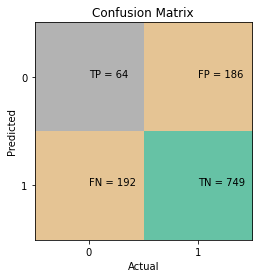

In [57]:
# feature extraction
features_train = get_features_m2(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df['genus'], test_size=0.3, random_state=100)

# train and validation
model = get_svm_predictions(X_train, X_val, y_train, y_val)

Make predictions on test images

In [58]:
# feature extraction - test data
features_test = get_features_m2(test_images)
print(features_test.shape)

# get model predictions
predictions = model.predict(features_test)

print(predictions)

(6, 40000)
[0. 1. 0. 0. 1. 0.]


#### M3

- Preprocessing - gray scaling <br>
- Features - edge map to vector<br>
- Algorithm - SVM <br>

For edge detection, we use Canny edge detection algorithm in this example.

In [59]:
# method to get image features
def get_features_m3(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

(3969, 40000)
Accuracy: 0.7884130982367759


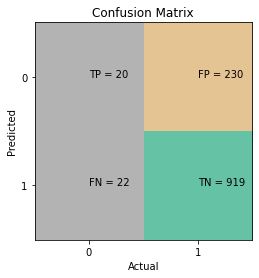

In [60]:
# feature extraction
features_train = get_features_m3(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df['genus'], test_size=0.3, random_state=100)

# train and validation
model = get_svm_predictions(X_train, X_val, y_train, y_val)

Make predictions on test images

In [61]:
# feature extraction - test data
features_test = get_features_m3(test_images)
print(features_test.shape)

# get model predictions
predictions = model.predict(features_test)

print(predictions)

(6, 40000)
[1. 1. 1. 1. 1. 1.]


#### M4
- Preprocessing - gray scaling <br>
- Features - HOG features<br>
- Algorithm - SVM <br>

In [62]:
# method to get image features
def get_features_m4(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image if necessary
    img_resized = cv2.resize(img_grayscaled, (64, 128))

    # feature extraction
    features, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

Train and validate model

(3969, 3780)
Accuracy: 0.670864819479429


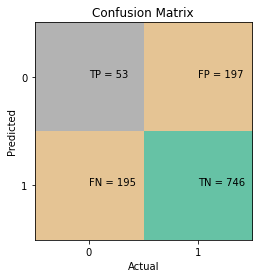

In [63]:
# feature extraction
features_train = get_features_m4(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df['genus'], test_size=0.3, random_state=100)

# train and validation
model = get_svm_predictions(X_train, X_val, y_train, y_val)

Make predictions on test images

In [65]:
# feature extraction - test data
features_test = get_features_m4(test_images)
print(features_test.shape)

# get model predictions
predictions = model.predict(features_test)
print(predictions)

(6, 3780)
[1. 0. 1. 1. 1. 1.]


Make predictions on test images

#### Summary

|Model | Preprocessing | Features   | Accuracy|
|------|---------------|------------|---------|
|M1    | gray scaling   | image vector | 0.7028 |
|M2    | gray scaling, smoothing| image vector | 0.6826 |
|M3    | gray scaling | edge map to vector | 0.7884 |
|M4    | gray scaling | HOG features | 0.6709 |


#### M5
- Preprocessing - gray scaling <br>
- Features - 1000 priciple components of edge map vector<br>
- Algorithm - SVM <br>

In [67]:
# method to get image features
def get_features_m5(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features = edges_canny.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  
  return features_list


Train and validate model

In [ ]:
# feature extraction
features_train = get_features_m5(train_images)
print(features_train.shape)

# Principal component extraction
pca = PCA(n_components=1000)
pca.fit(features_train)
features_train_updated = pca.transform(features_train)
print(features_train_updated.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train_updated, df['genus'], test_size=0.3, random_state=100)

# train and validation
model = get_svm_predictions(X_train, X_val, y_train, y_val)

(3969, 40000)
(3969, 1000)


Make predictions on test images

In [ ]:
# feature extraction - test data
features_test = get_features_m4(test_images)
print(features_test.shape)

# Principal component extraction - test data
features_test_updated = pca.transform(features_test)

# get model predictions
predictions = model.predict(features_test_updated)
print(predictions)

#### M6

Let's try to combine features.

- Preprocessing - gray scaling <br>
- Features - image vector + edge map vector<br>
- Algorithm - SVM <br>

In [ ]:
# method to get image features
def get_features_m6(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    # feature extraction
    edges_canny = cv2.Canny(img_grayscaled, 100, 200) 
    features1 = img_grayscaled.flatten()
    features2 = edges_canny.flatten()
    features = np.hstack((features1, features2))

    # vectorise/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(3969, 80000)


Train and validate model

Accuracy: 0.7674223341729639


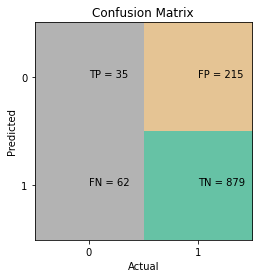

In [ ]:
# feature extraction
features_train = get_features_m6(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df['genus'], test_size=0.3, random_state=100)

# train and validation
model = get_svm_predictions(X_train, X_val, y_train, y_val)

Make predictions on test images

In [ ]:
# feature extraction - test data
features_test = get_features_m6(test_images)
print(features_test.shape)

# get model predictions
predictions = model.predict(features_test)
print(predictions)

**Exercise**

Try different image preprocessing and feature extraction methods to see whether you can improve the accuray. <br>
Similarly try the impact by different ML models.